# Recurrent Neural Network - Word Classification
## Using Seq2Seq model
Implemented in TensorFlow. Using bidirectual RNN as encoder and decoder implemented as tf.nn.raw_rnn

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import tensorflow as tf
from tensorflow.python.ops.rnn_cell_impl import LSTMCell, LSTMStateTuple
import time

from ocr.datahelpers import loadWordsData, correspondingShuffle
from ocr.mlhelpers import TrainingPlot

%matplotlib notebook
# Increase size of images
plt.rcParams['figure.figsize'] = (9.0, 5.0)

tf.reset_default_graph()
sess = tf.InteractiveSession()
print('Tensorflow', tf.__version__)

Tensorflow 1.2.1


### Loading images

In [2]:
images, labels, _ = loadWordsData()

Loading words...
Number of Images: 1008


In [3]:
CHARS = ['A', 'a', 'Á', 'á', 'B', 'b', 'C', 'c', 'Č', 'č',
         'D', 'd', 'Ď', 'ď', 'E', 'e', 'É', 'é', 'Ě', 'ě',
         'F', 'f', 'G', 'g', 'H', 'h', 'I', 'i', 'Í', 'í',         
         'J', 'j', 'K', 'k', 'L', 'l', 'M', 'm', 'N', 'n',
         'Ň', 'ň', 'O', 'o', 'Ó', 'ó', 'P', 'p', 'Q', 'q',
         'R', 'r', 'Ř', 'ř', 'S', 's', 'Š', 'š', 'T', 't',
         'Ť', 'ť', 'U', 'u', 'Ú', 'ú', 'Ů', 'ů', 'V', 'v',
         'W', 'w', 'X', 'x', 'Y', 'y', 'Ý', 'ý', 'Z', 'z',
         'Ž', 'ž']

char_size = len(CHARS)
print("Number of chars:", char_size)

Number of chars: 82


## Settings

In [4]:
PAD = 0   # Padding
EOS = 1   # End of seq

num_buckets = 5
slider_size = (60, 30)
N_INPUT = 30*60               # Size of sequence input vector
vocab_size = char_size + 2    # Number of different chars + <PAD> and <EOS>
input_embedding_size = 40     # Size of vector for embedding chars2vec

encoder_hidden_units = 60
decoder_hidden_units = 4 * encoder_hidden_units  # 4* is neccesary due to the concat (probably)
final_hidden_units = 2 * encoder_hidden_units

learning_rate = 1e-4
train_per = 0.8               # Percentage of training data

TRAIN_STEPS = 10000           # Number of training steps!
TEST_ITER = 150
LOSS_ITER = 50
SAVE_ITER = 2000
BATCH_SIZE = 64
EPOCH = 1000                  # Number of batches in epoch - not accurate

## Dataset

In [5]:
# Shuffle data for later splitting
images, labels = correspondingShuffle(images, labels)

idxs = [i+2 for i in range(char_size)]
idx_to_chars = dict(zip(idxs, CHARS))
chars_to_idx = dict(zip(CHARS, idxs))

labels_idx = np.empty(len(labels), dtype=object)
for i, label in enumerate(labels):
    labels_idx[i] = [chars_to_idx[c] for c in label]

# Split data on train and test dataset
div = int(0.80 * len(images))

trainImages = images[0:div]
testImages = images[div:]

trainLabels_idx = labels_idx[0:div]
testLabels_idx = labels_idx[div:]

print("Training images:", div)
print("Testing images:", len(images) - div)

Training images: 806
Testing images: 202


In [6]:
class BucketDataIterator():
    """ Iterator for feeding seq2seq model during training """
    def __init__(self, images, targets, num_buckets=5, slider=(60, 30)):
        # First PADDING of images to slider size ( -(a // b) ==  ceil(a/b))
        self.slider = slider
        for i in images:
            i.resize((i.shape[0], -(-i.shape[1] // slider[1]) * slider[1]),
                     refcheck=False)
        in_length = [image.shape[1]//slider[1] for image in images]
        # Split images to sequence of vectors
        imgseq = np.empty(len(images), dtype=object)
        for i, img in enumerate(images):
            imgseq[i] = [img[:, loc*slider[1]:(loc+1)*slider[1]].flatten()
                         for loc in range(in_length[i])]
        
        # Add EOS symbol to each output sequence
        for t in targets:
            t.append(EOS)           
        # Create pandas dataFrame and sort it by images width (length) 
        self.dataFrame = pd.DataFrame({'in_length': in_length,
                                       'out_length': [len(t) for t in targets],
                                       'images': imgseq,
                                       'targets': targets
                                      }).sort_values('in_length').reset_index(drop=True)

        bsize = int(len(images) / num_buckets)
        self.num_buckets = num_buckets
        
        # Create buckets by slicing parts by indexes
        self.buckets = []
        for bucket in range(num_buckets-1):
            self.buckets.append(self.dataFrame.iloc[bucket*bsize:(bucket+1)*bsize-1])
        self.buckets.append(self.dataFrame.iloc[num_buckets-1*bsize:])        
        
        self.buckets_size = [len(bucket) for bucket in self.buckets]

        # cursor[i] will be the cursor for the ith bucket
        self.cursor = np.array([0] * num_buckets)
        self.bucket_order = np.random.permutation(num_buckets)
        self.bucket_cursor = 0
        self.shuffle()
        print("Iterator created.")

    def shuffle(self, idx=None):
        """ Shuffle idx bucket or each bucket separately """
        for i in [idx] if idx is not None else range(self.num_buckets):
            self.buckets[i] = self.buckets[i].sample(frac=1).reset_index(drop=True)
            self.cursor[i] = 0


    def next_batch(self, batch_size):
        """
        Creates next training batch of size: batch_size
        Retruns: image seq, letter seq,
                 image seq lengths, letter seq lengths
        """
        i_bucket = self.bucket_order[self.bucket_cursor]
        # Increment cursor and shuffle in case of new round
        self.bucket_cursor = (self.bucket_cursor + 1) % self.num_buckets
        if self.bucket_cursor == 0:
            self.bucket_order = np.random.permutation(self.num_buckets)
            
        if self.cursor[i_bucket] + batch_size > self.buckets_size[i_bucket]:
            self.shuffle(i_bucket)

        # Handle too big batch sizes
        if (batch_size > self.buckets_size[i_bucket]):
            batch_size = self.buckets_size[i_bucket]

        res = self.buckets[i_bucket].iloc[self.cursor[i_bucket]:
                                          self.cursor[i_bucket]+batch_size]
        self.cursor[i_bucket] += batch_size

        # PAD input sequence and output
        # Pad sequences with <PAD> to same length
        input_max = max(res['in_length'])
        output_max = max(res['out_length'])
        assert input_max + 10 >= output_max   # In order to make it work
        
        input_seq = np.zeros((batch_size, input_max, N_INPUT), dtype=np.float32)
        for i, img in enumerate(res['images']):
            input_seq[i][:res['in_length'].values[i]] = img
        input_seq = input_seq.swapaxes(0, 1)
        
        # Need to pad according to the input size
        targets = np.zeros([batch_size, input_max+10], dtype=np.int32)
        for i, target in enumerate(targets):
            target[:res['out_length'].values[i]] = res['targets'].values[i]
        targets = targets.swapaxes(0, 1)
        
        return input_seq, targets, res['in_length'].values, res['out_length'].values
    
    def next_feed(self, size):
        """ Create feed directly for model training """
        (encoder_inputs_,
         decoder_targets_,
         encoder_input_lengths_,
         _) = self.next_batch(size)
        return {
            encoder_inputs: encoder_inputs_,
            encoder_inputs_length: encoder_input_lengths_,
            decoder_targets: decoder_targets_
        }


# Create iterator for feeding RNN
# Create only once, it modifies: labels_idx
train_iterator = BucketDataIterator(trainImages, trainLabels_idx, num_buckets, slider_size)
test_iterator = BucketDataIterator(testImages, testLabels_idx, num_buckets, slider_size)

Iterator created.
Iterator created.


In [7]:
# Input placehodlers
# N_INPUT -> size of vector representing one image in sequence
# Encoder inputs shape (max_seq_length, batch_size, vec_size)
encoder_inputs = tf.placeholder(shape=(None, None, N_INPUT),
                                dtype=tf.float32,
                                name='encoder_inputs')
encoder_inputs_length = tf.placeholder(shape=(None),
                                       dtype=tf.int32,
                                       name='encoder_inputs_length')
decoder_targets = tf.placeholder(shape=(None, None),
                                 dtype=tf.int32,
                                 name='decoder_targets')

In [8]:
# Randomly initialized embedding matrix, for characters embedding in decoder
embeddings = tf.Variable(tf.random_uniform([vocab_size,
                                            input_embedding_size],
                                           -1.0,
                                           1.0), dtype=tf.float32)

## Encoder

In [9]:
enc_cell_fw = LSTMCell(num_units=encoder_hidden_units,
                       state_is_tuple=True)
enc_cell_bw = LSTMCell(num_units=encoder_hidden_units,
                       state_is_tuple=True)

In [10]:
# Bidirectional RNN, gibe fw and bw outputs separately
((fw_outputs, bw_outputs),
 (fw_final_state, bw_final_state)) = (
    tf.nn.bidirectional_dynamic_rnn(cell_fw = enc_cell_fw,
                                    cell_bw = enc_cell_bw,
                                    inputs = encoder_inputs,
                                    sequence_length = encoder_inputs_length,
                                    dtype = tf.float32,
                                    time_major = True))

In [11]:
#Concatenates tensors along one dimension.
encoder_outputs = tf.concat((fw_outputs, bw_outputs), 2)

#TF Tuple used by LSTM Cells for state_size, zero_state, and output state.
encoder_final_state = LSTMStateTuple(
    c=tf.concat((fw_final_state.c,
                 bw_final_state.c), 1),
    h=tf.concat((fw_final_state.h,
                 bw_final_state.h), 1))

## Decoder

In [12]:
decoder_cell = LSTMCell(num_units=final_hidden_units,
                        state_is_tuple=True)

In [13]:
encoder_max_time, batch_size, _ = tf.unstack(tf.shape(encoder_inputs))
# +9 additional steps, +1 leading <EOS> token for decoder inputs
decoder_lengths = encoder_inputs_length + 10

In [14]:
# Weights and bias for output
# W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype=tf.float32)
# b = tf.variable(tf.zeros([vocab_size]), dtype=tf.float32)

W = {'score': tf.Variable(tf.truncated_normal(shape=[final_hidden_units, final_hidden_units]),
                          dtype=tf.float32,
                          name='weight_score'),
     'hdash': tf.Variable(tf.truncated_normal(shape=[decoder_hidden_units, decoder_hidden_units]),
                          dtype=tf.float32,
                          name='weight_hdash'),
     'decoder': tf.Variable(tf.truncated_normal(shape=[decoder_hidden_units, vocab_size]),
                            dtype=tf.float32,
                            name='weight_decoder')}

b = {'hdash': tf.Variable(tf.constant(0.1, shape=[decoder_hidden_units,]),
                          dtype=tf.float32,
                          name='bias_hdash'),
     'decoder': tf.Variable(tf.constant(0.1, shape=[vocab_size,]),
                            dtype=tf.float32,
                            name='bias_decoder')}

In [15]:
# Prapare PAD and EOS slices
# Expected values due to tf.zeros and tf.ones
assert EOS == 1 and PAD == 0

pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')
eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')

eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

In [16]:
# Initial loop function when: time == 0
def loop_initial():
    initial_elements_finished = (0 >= decoder_lengths)  # All false
    initial_input = eos_step_embedded # EOS is used also as starting input
    initial_cell_state = encoder_final_state # Starting with encoder final state
    initial_cell_output = None
    initial_loop_state = None
    return (initial_elements_finished,
            initial_input,
            initial_cell_state,
            initial_cell_output,
            initial_loop_state)

In [17]:
# Transition loop function when: time > 0
def loop_transition(time, previous_output, previous_state, previous_loop_state):
    def get_next_input():
        # Feeding previous output as next input of RNN
        # output_logits = tf.add(tf.matmul(previous_output, W), b)
        # prediction = tf.argmax(output_logits, axis=1)
        # next_input = tf.nn.embedding_lookup(embeddings, prediction)
        #        
        # return next_input
        
        prev_out_with_weights = tf.matmul(previous_output, W['score'], name='prev-score')
        prev_out_with_weights = tf.reshape(prev_out_with_weights, [-1, final_hidden_units, 1])

        score = tf.matmul(tf.transpose(encoder_outputs, [1, 0, 2]), prev_out_with_weights, name='enc-prev')
        score = tf.reshape(score, [-1, encoder_max_time])
        
        attention = tf.nn.softmax(score)
        attention = tf.reshape(attention, [-1, 1, encoder_max_time])
        
        ct = tf.matmul(attention, tf.transpose(encoder_outputs, [1, 0, 2]), name='att-enc')
        ct = tf.reshape(ct, [-1, final_hidden_units])
        
        ctht = tf.concat((ct, previous_output), 1)
        ht_dash = tf.nn.tanh(tf.add(tf.matmul(ctht, W['hdash'], name='ctht-hdash'), b['hdash']))
        pred = tf.nn.softmax(tf.add(tf.matmul(ctht, W['decoder'], name='ctht-dec'), b['decoder']))
        
        prediction = tf.argmax(pred, axis=1)
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        return next_input
    
    # Defining if corresponding sequence has ended
    elements_finished = (time >= decoder_lengths)
    finished = tf.reduce_all(elements_finished) # -> boolean scalar
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    
    # Set previous to current
    state = previous_state
    output = previous_output
    loop_state = None

    return (elements_finished, 
            input,
            state,
            output,
            loop_state)

In [18]:
def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:    # time == 0
        return loop_initial()
    else:
        return loop_transition(time, previous_output, previous_state, previous_loop_state)

decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

In [19]:
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))

decoder_prev_out_with_weights = tf.matmul(decoder_outputs_flat,W['score'])
decoder_prev_out_with_weights = tf.reshape(decoder_prev_out_with_weights,[-1,decoder_max_steps,final_hidden_units])
encoder_outputs_new = tf.reshape(encoder_outputs,[-1,final_hidden_units,encoder_max_time])
decoder_score = tf.matmul(decoder_prev_out_with_weights,encoder_outputs_new)
decoder_attention = tf.nn.softmax(decoder_score)
encoder_outputs_new = tf.reshape(encoder_outputs,[-1,encoder_max_time,final_hidden_units])
decoder_ct = tf.matmul(decoder_attention,encoder_outputs_new)
decoder_outputs_flat_new = tf.reshape(decoder_outputs_flat,[-1,decoder_max_steps,decoder_dim])
decoder_ctht = tf.concat((decoder_ct,decoder_outputs_flat_new),2)
decoder_ctht = tf.reshape(decoder_ctht,[-1,decoder_hidden_units])
decoder_ctht_logits = tf.add(tf.matmul(decoder_ctht,W['hdash']),b['hdash'])
decoder_ctht_logits = tf.reshape(decoder_ctht_logits,[-1,decoder_max_steps,decoder_hidden_units])
decoder_ht_dash = tf.nn.tanh(decoder_ctht_logits)
decoder_ht_dash = tf.reshape(decoder_ht_dash,[-1,decoder_hidden_units])
decoder_ht_dash_logits = tf.add(tf.matmul(decoder_ht_dash,W['decoder']),b['decoder'])
decoder_ht_dash_logits = tf.reshape(decoder_ht_dash_logits,[decoder_max_steps, -1, vocab_size])
decoder_pred = tf.nn.softmax(decoder_ht_dash_logits)
decoder_pred_prediction = tf.argmax(decoder_pred,axis=2)
# decoder_pred_prediction = tf.reshape(decoder_pred_prediction,[-1,decoder_max_steps])

decoder_logits = decoder_ht_dash_logits
decoder_prediction = decoder_pred_prediction

In [20]:
# # Reduces dimensionality
# decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
# decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
# # Pass flattened tensor through decoder
# decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
# decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))
# # Final prediction
# decoder_prediction = tf.argmax(decoder_logits, 2)

### Optimizer

In [21]:
# Cross entropy loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

# Loss function
loss = tf.reduce_mean(cross_entropy)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Evaluate model
correct_prediction = tf.equal(decoder_prediction,
                              tf.cast(decoder_targets, tf.int64), name='Corr-pred')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Training

<IPython.core.display.Javascript object>


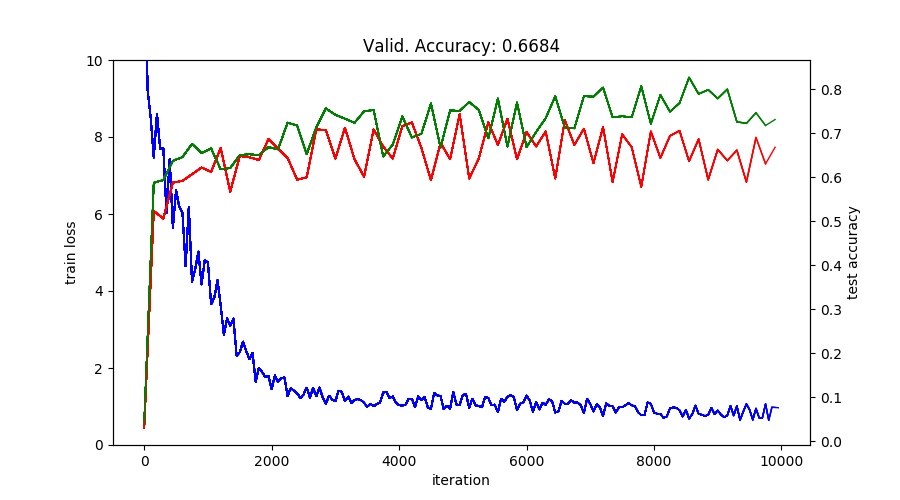

batch 0 - loss: 24.48587
    input     > [61 31 83  1  0  0  0  0  0  0  0  0  0  0  0]
    predicted > [60 12 12 33 64 28 37 26 33 79  8 14 72 68 65]

batch 1000 - loss: 4.5641603
    input     > [59 31 49  1  0  0  0  0  0  0  0  0  0  0]
    predicted > [57 19  0  0  1  0  0  0  0  0  0  0  0  0]

batch 2000 - loss: 1.793511
    input     > [16 53 29 35  1  0  0  0  0  0  0  0  0  0  0]
    predicted > [53 17 45  0  1  0  0  0  0  0  0  0  0  0  0]

batch 3000 - loss: 1.4625659
    input     > [29 41 13 29 25 45 71  5  1  0  0  0  0  0  0]
    predicted > [37  3  1  1  1  1  1  1  0  0  0 29  0  0  0]

batch 4000 - loss: 1.8247931
    input     > [27 53 69 81 45 57 61 53  3 59 41 79 39  1  0  0  0  0  0  0  0]
    predicted > [41  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0]

batch 5000 - loss: 1.2059733
    input     > [49 69 37  1  0  0  0  0  0  0  0  0  0  0]
    predicted > [45 45 13  1  0  0  0  0  0  0  0  0  0  0]

batch 6000 - loss: 2.0576353
    input     > 

In [22]:
sess.run(tf.global_variables_initializer())


# Creat plot for live stats ploting
trainPlot = TrainingPlot(TRAIN_STEPS, TEST_ITER, LOSS_ITER)

try:
    for i_batch in range(TRAIN_STEPS):
        fd = train_iterator.next_feed(BATCH_SIZE)
        train_step.run(fd)
        
        if i_batch % LOSS_ITER == 0:
            # Plotting loss
            tmpLoss = loss.eval(fd)
            trainPlot.updateCost(tmpLoss, i_batch // LOSS_ITER)
    
        if i_batch % TEST_ITER == 0:
            # Plotting accuracy
            fd_test = test_iterator.next_feed(BATCH_SIZE)
            accTest = accuracy.eval(fd_test)
            accTrain = accuracy.eval(fd)
            trainPlot.updateAcc(accTest, accTrain, i_batch // TEST_ITER)

        if i_batch % SAVE_ITER == 0:
            # TODO Implement saver
            pass
        
        if i_batch % EPOCH == 0:
            fd_test = test_iterator.next_feed(BATCH_SIZE)
            print('batch %r - loss: %r' % (i_batch, sess.run(loss, fd_test)))
            predict_ = sess.run(decoder_prediction, fd_test)
            for i, (inp, pred) in enumerate(zip(fd_test[decoder_targets].T, predict_.T)):
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 0:
                    break
            print()

except KeyboardInterrupt:
    # TODO add saving on interrup
    print('Training interrupted.')